In [46]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr, entropy, wasserstein_distance
from scipy.spatial.distance import jensenshannon, euclidean, cityblock

In [3]:
proj_dir = Path("..") / "Data/r77-mini-data-fortnight"
print(proj_dir.joinpath("input"))

data_dir = proj_dir
input_dir = data_dir.joinpath("input")
fixed_input_dir = input_dir.joinpath("fixed")
temporal_input_dir = input_dir.joinpath("temporal")
target_dir = data_dir.joinpath("target")
fixed_target_dir = target_dir.joinpath("fixed")
temporal_target_dir = target_dir.joinpath("temporal")

../Data/r77-mini-data-fortnight/input


In [4]:
files = list(temporal_target_dir.iterdir())


index_dir = Path("..")/"Index"
files_index = list(index_dir.iterdir())
indices = np.load(files_index[0]).squeeze()

#First hour of data
index = indices[0]
tt = np.load(files[index]).squeeze()
tt.shape

(144, 70, 100, 3)

In [5]:
files_ti = list(temporal_input_dir.iterdir())

In [6]:
data = []

for j in range(360):
    index = indices[j]

    tt = np.load(files[index]).squeeze()
    tt = np.transpose(tt, (0, 2, 3, 1))[:, :, :, :64]  #shape: (144, 100, 3, 64)

    ti = np.load(files_ti[index]).squeeze()
    ti = np.transpose(ti, (0, 2, 1))[:, :, :64]  #shape: (144, 3, 64)

    #ensure ti has the same second dimension as tt
    ti_expanded = np.repeat(ti[:, None, :, :], tt.shape[1], axis=1)  #shape: (144, 100, 3, 64)

    #calculate diff and reshape
    diff_data = tt - ti_expanded  #shape: (144, 100, 3, 64)
    reshaped_tt = diff_data.reshape(-1, 3, 64)  #shape: (14400, 3, 64)

    data.append(reshaped_tt)


data = np.concatenate(data).reshape(-1, 3, 64)

In [7]:
data.shape

(5184000, 3, 64)

In [8]:
def normalise(vector):
    min_val = np.min(vector)
    max_val = np.max(vector)
    normalised_vector = (vector - min_val) / (max_val - min_val)
    return normalised_vector, min_val, max_val

In [9]:

min_val = normalise(data)[1]
max_val = normalise(data)[2]

In [35]:
random_indices = np.random.choice(data.shape[0], 100, replace=False)
training_data = data[random_indices]
training_data.shape

(100, 3, 64)

In [36]:
sample_diff_dir = Path("Sample_diffs_0")
files_sample_diff = list(sample_diff_dir.iterdir())

sample_diffs = np.load(files_sample_diff[0]).squeeze()
sample_diffs.shape

(100, 3, 64)

In [37]:
def denormalise(normalised_vector, min_val, max_val):
    original_vector = normalised_vector * (max_val - min_val) + min_val
    return original_vector

In [38]:
sample = denormalise(sample_diffs, min_val, max_val)
sample.shape

(100, 3, 64)

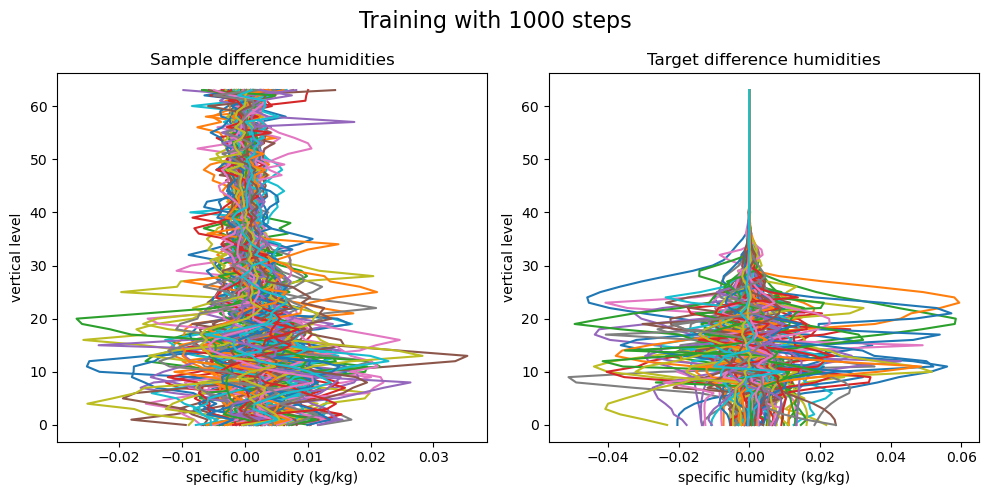

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#Sample humidities plot
sample_diff_humidity = sample[:, 0, :] 
for i in range(100):
    axs[0].plot(sample_diff_humidity[i], np.arange(64))
axs[0].set_xlabel("specific humidity (kg/kg)")
axs[0].set_ylabel("vertical level")
axs[0].set_title("Sample difference humidities")

# Target humidities plot
target_diff_humidity = training_data[:, 0, :] 
for i in range(100):
    axs[1].plot(target_diff_humidity[i], np.arange(64))
axs[1].set_xlabel("specific humidity (kg/kg)")
axs[1].set_ylabel("vertical level")
axs[1].set_title("Target difference humidities")

fig.suptitle("Training with 1000 steps", fontsize = 16)

plt.tight_layout()
plt.show()

In [47]:
#statistical similarity
mse = mean_squared_error(target_diff_humidity, sample_diff_humidity)
mae = mean_absolute_error(target_diff_humidity, sample_diff_humidity)
rmse = np.sqrt(mse)

sample_vector_reshaped = np.array(target_diff_humidity).reshape(1, -1)
generated_vector_reshaped = np.array(sample_diff_humidity).reshape(1, -1)
cosine_sim = cosine_similarity(sample_vector_reshaped, generated_vector_reshaped)[0][0]

spearman_corr, _ = spearmanr(target_diff_humidity, sample_diff_humidity)

#distribution similarity
sample_dist = np.array(target_diff_humidity) / np.sum(target_diff_humidity)
generated_dist = np.array(sample_diff_humidity) / np.sum(sample_diff_humidity)

kl_div = entropy(sample_dist, generated_dist)
js_div = jensenshannon(sample_dist, generated_dist)



#results
print(f"MSE: {mse}, MAE: {mae}, RMSE: {rmse}")
print(f"Cosine Similarity: {cosine_sim}")
print(f" Spearman Correlation: {spearman_corr}")
print(f"KL Divergence: {kl_div}, Jensen-Shannon Divergence: {js_div}")

MSE: 7.136409112717956e-05, MAE: 0.004004646558314562, RMSE: 0.00844772718846798
Cosine Similarity: -0.03843555599451065
 Spearman Correlation: [[ 1.00000000e+00  9.84878488e-01  9.49414941e-01 ...  8.41044104e-02
   2.31143114e-02 -6.67266727e-03]
 [ 9.84878488e-01  1.00000000e+00  9.85238524e-01 ...  5.69576958e-02
  -1.28892889e-02  2.28022802e-04]
 [ 9.49414941e-01  9.85238524e-01  1.00000000e+00 ...  2.61146115e-02
  -3.53795380e-02 -1.18811881e-02]
 ...
 [ 8.41044104e-02  5.69576958e-02  2.61146115e-02 ...  1.00000000e+00
   2.52913291e-01  9.28292829e-02]
 [ 2.31143114e-02 -1.28892889e-02 -3.53795380e-02 ...  2.52913291e-01
   1.00000000e+00  5.18871887e-01]
 [-6.67266727e-03  2.28022802e-04 -1.18811881e-02 ...  9.28292829e-02
   5.18871887e-01  1.00000000e+00]]
KL Divergence: [inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf in

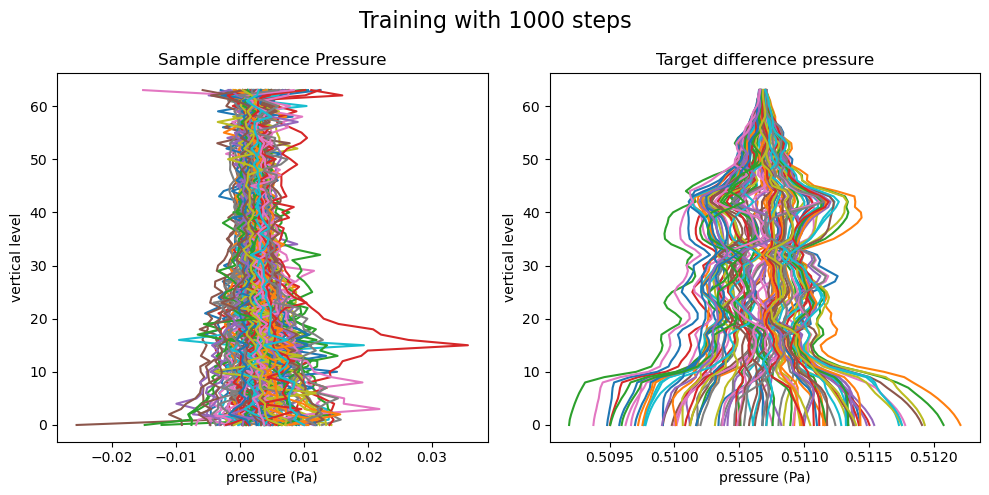

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#Sample humidities plot
sample_diff_pressure = sample[:, 1, :] 
for i in range(100):
    axs[0].plot(sample_diff_pressure[i], np.arange(64))
axs[0].set_xlabel("pressure (Pa)")
axs[0].set_ylabel("vertical level")
axs[0].set_title("Sample difference Pressure")

# Target humidities plot
target_diff_pressure = training_data[:, 1, :] 
for i in range(100):
    axs[1].plot(target_diff_pressure[i], np.arange(64))
axs[1].set_xlabel("pressure (Pa)")
axs[1].set_ylabel("vertical level")
axs[1].set_title("Target difference pressure")

fig.suptitle("Training with 1000 steps", fontsize = 16)

plt.tight_layout()
plt.show()

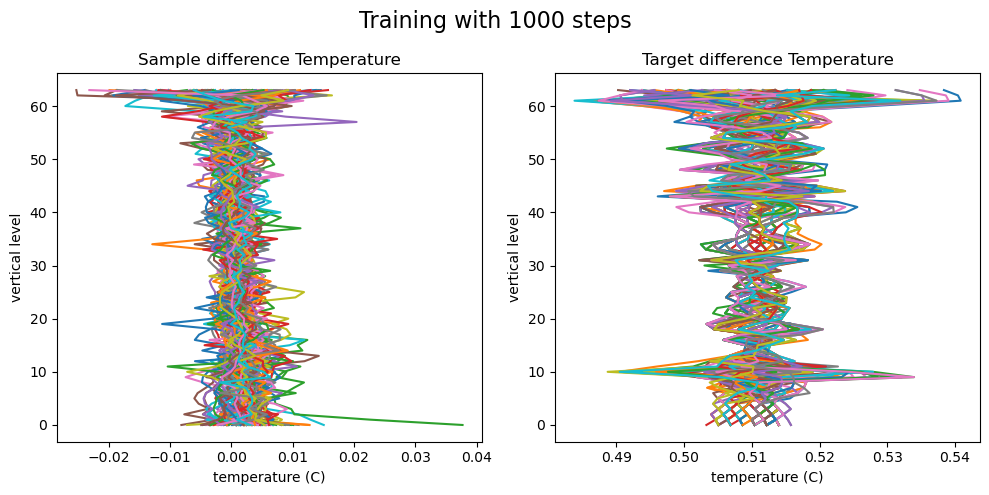

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#Sample humidities plot
sample_diff_temperature = sample[:, 2, :] 
for i in range(100):
    axs[0].plot(sample_diff_temperature[i], np.arange(64))
axs[0].set_xlabel("temperature (C)")
axs[0].set_ylabel("vertical level")
axs[0].set_title("Sample difference Temperature")


# Target humidities plot
target_diff_temperature = training_data[:, 2, :] 
for i in range(100):
    axs[1].plot(target_diff_temperature[i], np.arange(64))
axs[1].set_xlabel("temperature (C)")
axs[1].set_ylabel("vertical level")
axs[1].set_title("Target difference Temperature")

fig.suptitle("Training with 1000 steps", fontsize = 16)

plt.tight_layout()
plt.show()

In [48]:
sample_diff_dir = Path("Sample_diffs_1")
files_sample_diff = list(sample_diff_dir.iterdir())

sample_diffs = np.load(files_sample_diff[0]).squeeze()
sample_diffs.shape
sample = denormalise(sample_diffs, min_val, max_val)

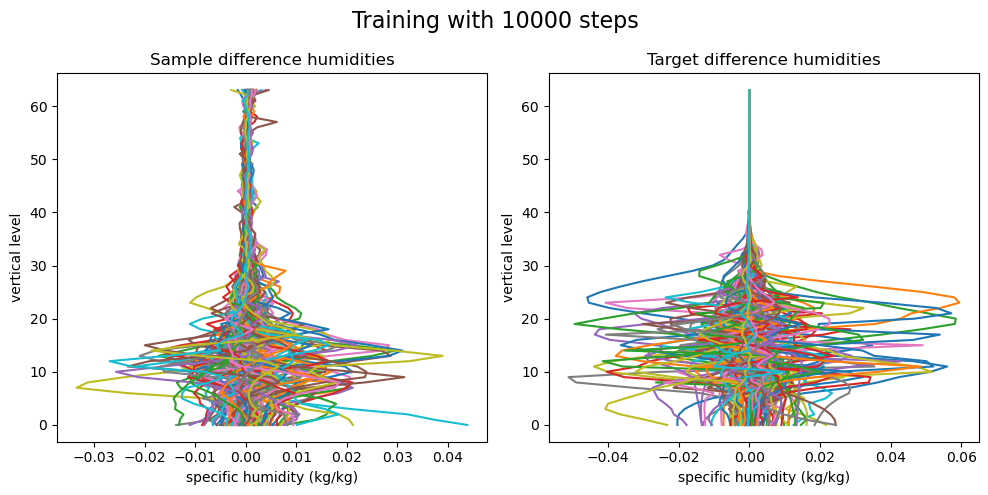

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#Sample humidities plot
sample_diff_humidity = sample[:, 0, :] 
for i in range(100):
    axs[0].plot(sample_diff_humidity[i], np.arange(64))
axs[0].set_xlabel("specific humidity (kg/kg)")
axs[0].set_ylabel("vertical level")
axs[0].set_title("Sample difference humidities")


# Target humidities plot
target_diff_humidity = training_data[:, 0, :] 
for i in range(100):
    axs[1].plot(target_diff_humidity[i], np.arange(64))
axs[1].set_xlabel("specific humidity (kg/kg)")
axs[1].set_ylabel("vertical level")
axs[1].set_title("Target difference humidities")

fig.suptitle("Training with 10000 steps", fontsize = 16)

plt.tight_layout()
plt.show()

In [67]:
#statistical similarity
target = normalise(data)[0]
target.shape

(5184000, 3, 64)

In [70]:
target_mean = np.mean(target[:,0,:], axis= 0)
sample_mean = np.mean(sample_diff_humidity, axis=0)
target_variance= np.var(target[:,0,:], axis= 0)
sample_variance = np.var(sample_diff_humidity, axis=0)

mse_mean = mean_squared_error(target_mean, sample_mean)
mse_variance = mean_squared_error(target_variance, sample_variance)



#results
print(f"MSE Mean: {mse_mean}, MSE Variance: {mse_variance}")



MSE Mean: 0.2516826093196869, MSE Variance: 2.0457150640140753e-07


In [ ]:
#distribution similarity
sample_dist = np.array(target_diff_humidity) / np.sum(target_diff_humidity)
generated_dist = np.array(sample_diff_humidity) / np.sum(sample_diff_humidity)

epsilon = 1e-10
sample_dist = np.clip(sample_dist, epsilon, None)
generated_dist = np.clip(generated_dist, epsilon, None)

kl_div = entropy(sample_dist, generated_dist)
js_div = jensenshannon(sample_dist, generated_dist)




print(f"KL Divergence: {kl_div}, Jensen-Shannon Divergence: {js_div}")

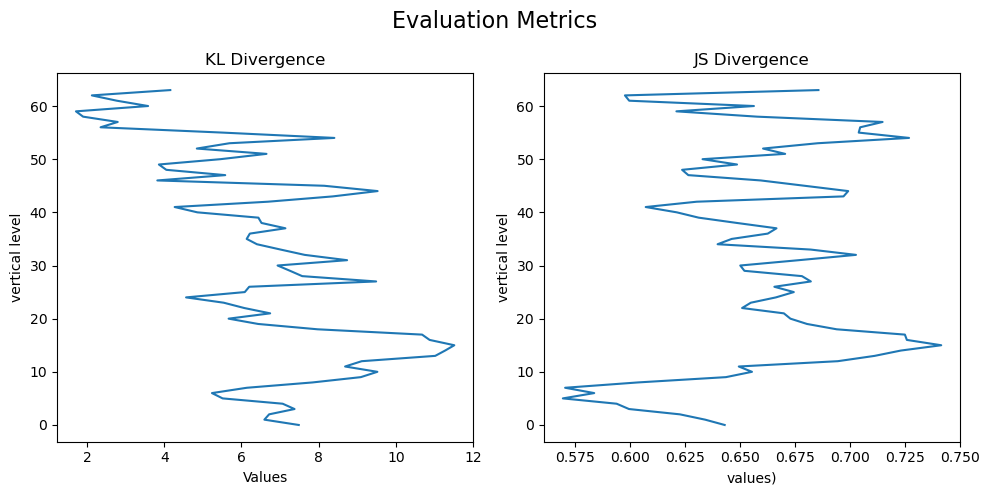

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(kl_div, np.arange(64))
axs[0].set_xlabel("Values")
axs[0].set_ylabel("vertical level")
axs[0].set_title("KL Divergence")

axs[1].plot(js_div, np.arange(64))
axs[1].set_xlabel("values)")
axs[1].set_ylabel("vertical level")
axs[1].set_title("JS Divergence")

fig.suptitle("Evaluation Metrics", fontsize = 16)

plt.tight_layout()
plt.show()

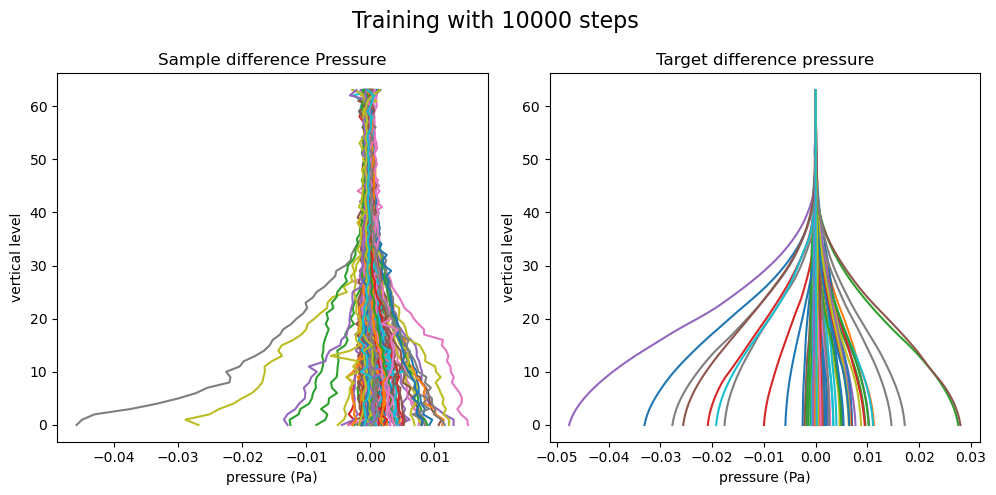

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#Sample humidities plot
sample_diff_pressure = sample[:, 1, :] 
for i in range(100):
    axs[0].plot(sample_diff_pressure[i], np.arange(64))
axs[0].set_xlabel("pressure (Pa)")
axs[0].set_ylabel("vertical level")
axs[0].set_title("Sample difference Pressure")


# Target humidities plot
target_diff_pressure = training_data[:, 1, :] 
for i in range(100):
    axs[1].plot(target_diff_pressure[i], np.arange(64))
axs[1].set_xlabel("pressure (Pa)")
axs[1].set_ylabel("vertical level")
axs[1].set_title("Target difference pressure")

fig.suptitle("Training with 10000 steps", fontsize = 16)

plt.tight_layout()
plt.show()

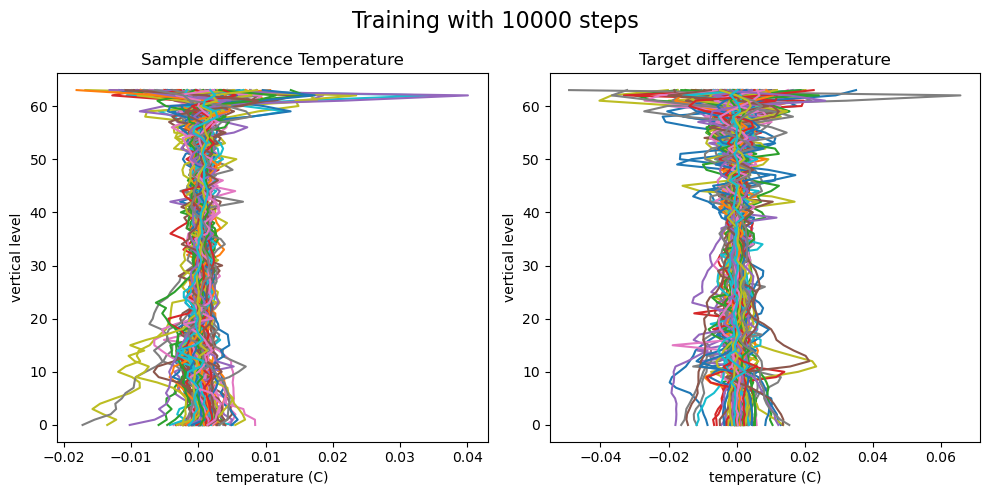

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#Sample humidities plot
sample_diff_temperature = sample[:, 2, :] 
for i in range(100):
    axs[0].plot(sample_diff_temperature[i], np.arange(64))
axs[0].set_xlabel("temperature (C)")
axs[0].set_ylabel("vertical level")
axs[0].set_title("Sample difference Temperature")

# Target humidities plot
target_diff_temperature = training_data[:, 2, :] 
for i in range(100):
    axs[1].plot(target_diff_temperature[i], np.arange(64))
axs[1].set_xlabel("temperature (C)")
axs[1].set_ylabel("vertical level")
axs[1].set_title("Target difference Temperature")

fig.suptitle("Training with 10000 steps", fontsize = 16)

plt.tight_layout()
plt.show()

In [85]:
sample_diff_dir = Path("Sample_diffs_2")
files_sample_diff = list(sample_diff_dir.iterdir())

sample_diffs = np.load(files_sample_diff[0]).squeeze()
sample_diffs.shape
sample = denormalise(sample_diffs, min_val, max_val)

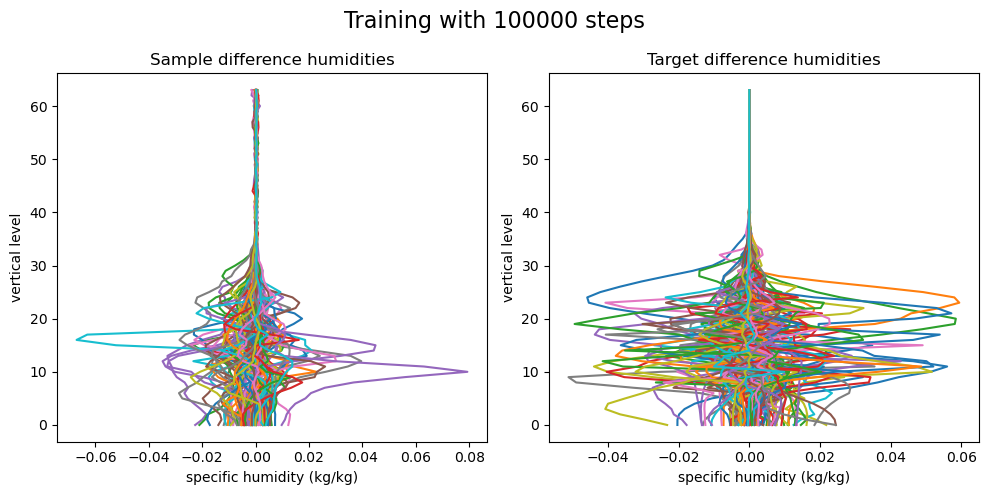

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#Sample humidities plot
sample_diff_humidity = sample[:, 0, :] 
for i in range(100):
    axs[0].plot(sample_diff_humidity[i], np.arange(64))
axs[0].set_xlabel("specific humidity (kg/kg)")
axs[0].set_ylabel("vertical level")
axs[0].set_title("Sample difference humidities")


# Target humidities plot
target_diff_humidity = training_data[:, 0, :] 
for i in range(100):
    axs[1].plot(target_diff_humidity[i], np.arange(64))
axs[1].set_xlabel("specific humidity (kg/kg)")
axs[1].set_ylabel("vertical level")
axs[1].set_title("Target difference humidities")

fig.suptitle("Training with 100000 steps", fontsize = 16)

plt.tight_layout()
plt.show()

In [87]:
target_mean = np.mean(target[:,0,:], axis= 0)
sample_mean = np.mean(sample_diff_humidity, axis=0)
target_variance= np.var(target[:,0,:], axis= 0)
sample_variance = np.var(sample_diff_humidity, axis=0)

mse_mean = mean_squared_error(target_mean, sample_mean)
mse_variance = mean_squared_error(target_variance, sample_variance)



#results
print(f"MSE Mean: {mse_mean}, MSE Variance: {mse_variance}")

MSE Mean: 0.2527313828468323, MSE Variance: 1.8935097045869043e-07


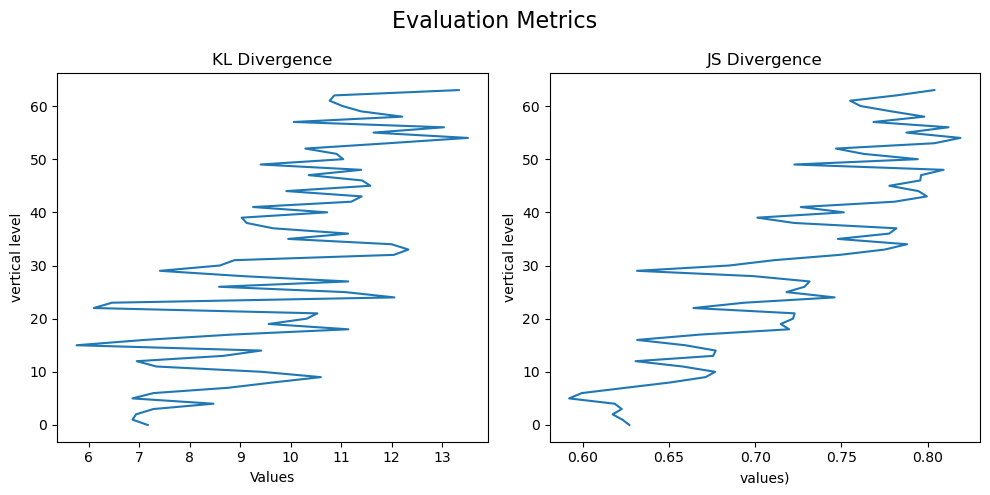

In [88]:
#distribution similarity
sample_dist = np.array(target_diff_humidity) / np.sum(target_diff_humidity)
generated_dist = np.array(sample_diff_humidity) / np.sum(sample_diff_humidity)

epsilon = 1e-10
sample_dist = np.clip(sample_dist, epsilon, None)
generated_dist = np.clip(generated_dist, epsilon, None)

kl_div = entropy(sample_dist, generated_dist)
js_div = jensenshannon(sample_dist, generated_dist)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(kl_div, np.arange(64))
axs[0].set_xlabel("Values")
axs[0].set_ylabel("vertical level")
axs[0].set_title("KL Divergence")

axs[1].plot(js_div, np.arange(64))
axs[1].set_xlabel("values)")
axs[1].set_ylabel("vertical level")
axs[1].set_title("JS Divergence")

fig.suptitle("Evaluation Metrics", fontsize = 16)

plt.tight_layout()
plt.show()


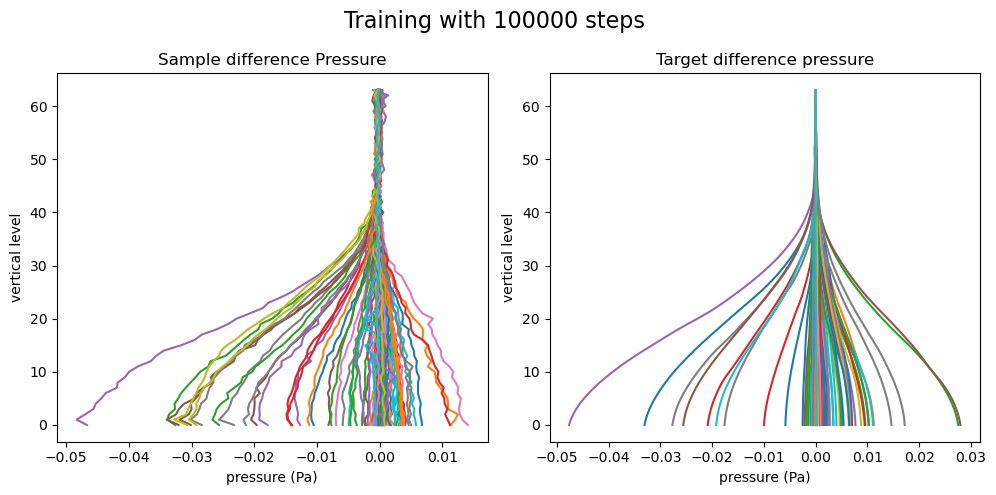

In [89]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#Sample humidities plot
sample_diff_pressure = sample[:, 1, :] 
for i in range(100):
    axs[0].plot(sample_diff_pressure[i], np.arange(64))
axs[0].set_xlabel("pressure (Pa)")
axs[0].set_ylabel("vertical level")
axs[0].set_title("Sample difference Pressure")


# Target humidities plot
target_diff_pressure = training_data[:, 1, :] 
for i in range(100):
    axs[1].plot(target_diff_pressure[i], np.arange(64))
axs[1].set_xlabel("pressure (Pa)")
axs[1].set_ylabel("vertical level")
axs[1].set_title("Target difference pressure")

fig.suptitle("Training with 100000 steps", fontsize = 16)

plt.tight_layout()
plt.show()

In [90]:
target_mean = np.mean(target[:,1,:], axis= 0)
sample_mean = np.mean(sample_diff_pressure, axis=0)
target_variance= np.var(target[:,1,:], axis= 0)
sample_variance = np.var(sample_diff_pressure, axis=0)

mse_mean = mean_squared_error(target_mean, sample_mean)
mse_variance = mean_squared_error(target_variance, sample_variance)



#results
print(f"MSE Mean: {mse_mean}, MSE Variance: {mse_variance}")

MSE Mean: 0.2529178261756897, MSE Variance: 4.428542510481748e-08


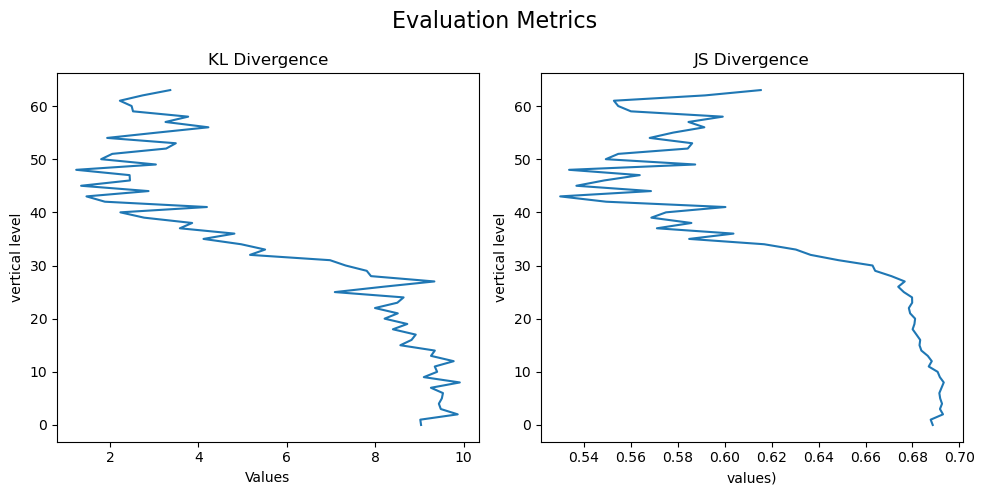

In [91]:
#distribution similarity
sample_dist = np.array(target_diff_pressure) / np.sum(target_diff_pressure)
generated_dist = np.array(sample_diff_pressure) / np.sum(sample_diff_pressure)

epsilon = 1e-10
sample_dist = np.clip(sample_dist, epsilon, None)
generated_dist = np.clip(generated_dist, epsilon, None)

kl_div = entropy(sample_dist, generated_dist)
js_div = jensenshannon(sample_dist, generated_dist)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(kl_div, np.arange(64))
axs[0].set_xlabel("Values")
axs[0].set_ylabel("vertical level")
axs[0].set_title("KL Divergence")

axs[1].plot(js_div, np.arange(64))
axs[1].set_xlabel("values)")
axs[1].set_ylabel("vertical level")
axs[1].set_title("JS Divergence")

fig.suptitle("Evaluation Metrics", fontsize = 16)

plt.tight_layout()
plt.show()

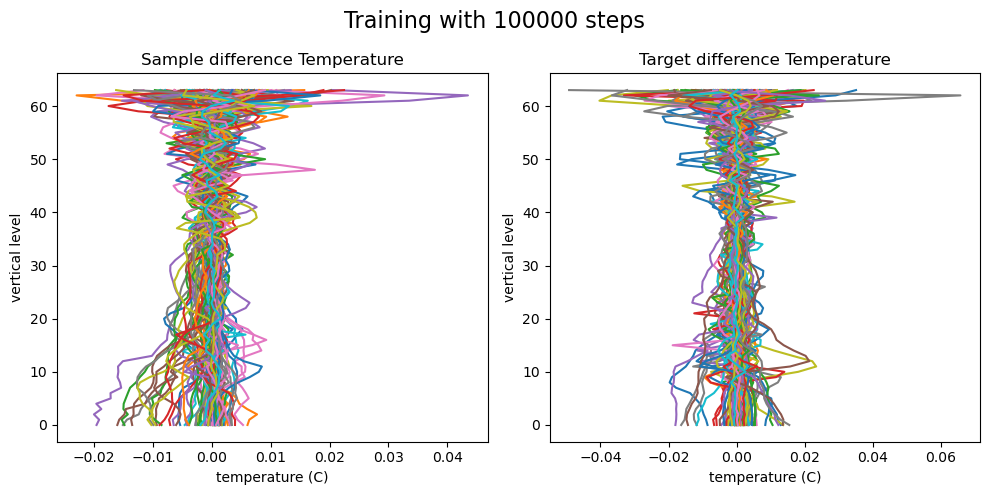

In [92]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#Sample humidities plot
sample_diff_temperature = sample[:, 2, :] 
for i in range(100):
    axs[0].plot(sample_diff_temperature[i], np.arange(64))
axs[0].set_xlabel("temperature (C)")
axs[0].set_ylabel("vertical level")
axs[0].set_title("Sample difference Temperature")

# Target humidities plot
target_diff_temperature = training_data[:, 2, :] 
for i in range(100):
    axs[1].plot(target_diff_temperature[i], np.arange(64))
axs[1].set_xlabel("temperature (C)")
axs[1].set_ylabel("vertical level")
axs[1].set_title("Target difference Temperature")

fig.suptitle("Training with 100000 steps", fontsize = 16)

plt.tight_layout()
plt.show()

In [93]:
target_mean = np.mean(target[:,2,:], axis= 0)
sample_mean = np.mean(sample_diff_temperature, axis=0)
target_variance= np.var(target[:,2,:], axis= 0)
sample_variance = np.var(sample_diff_temperature, axis=0)

mse_mean = mean_squared_error(target_mean, sample_mean)
mse_variance = mean_squared_error(target_variance, sample_variance)



#results
print(f"MSE Mean: {mse_mean}, MSE Variance: {mse_variance}")

MSE Mean: 0.2522337734699249, MSE Variance: 3.795367575776254e-08


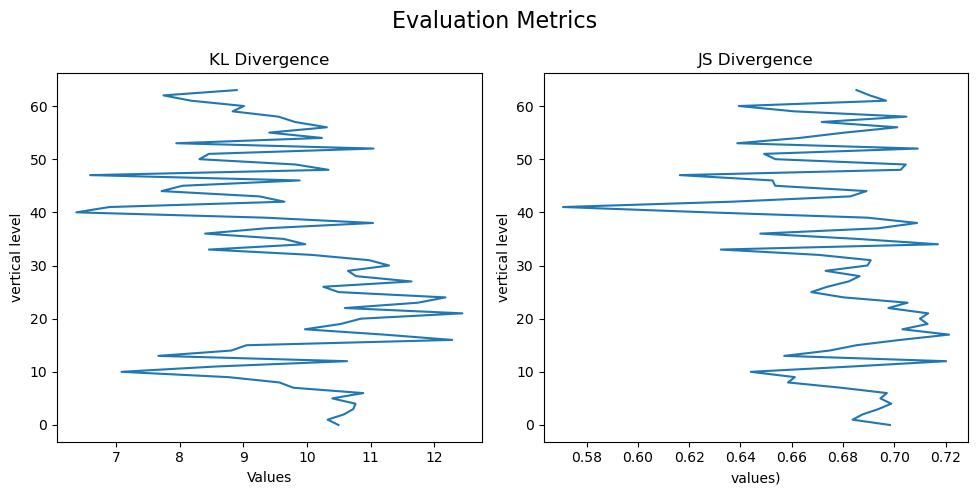

In [94]:
#distribution similarity
sample_dist = np.array(target_diff_temperature) / np.sum(target_diff_temperature)
generated_dist = np.array(sample_diff_temperature) / np.sum(sample_diff_temperature)

epsilon = 1e-10
sample_dist = np.clip(sample_dist, epsilon, None)
generated_dist = np.clip(generated_dist, epsilon, None)

kl_div = entropy(sample_dist, generated_dist)
js_div = jensenshannon(sample_dist, generated_dist)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(kl_div, np.arange(64))
axs[0].set_xlabel("Values")
axs[0].set_ylabel("vertical level")
axs[0].set_title("KL Divergence")

axs[1].plot(js_div, np.arange(64))
axs[1].set_xlabel("values)")
axs[1].set_ylabel("vertical level")
axs[1].set_title("JS Divergence")

fig.suptitle("Evaluation Metrics", fontsize = 16)

plt.tight_layout()
plt.show()